# Introduction

Objective:
    
Background:

Data: 
https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_products_dataset.csv

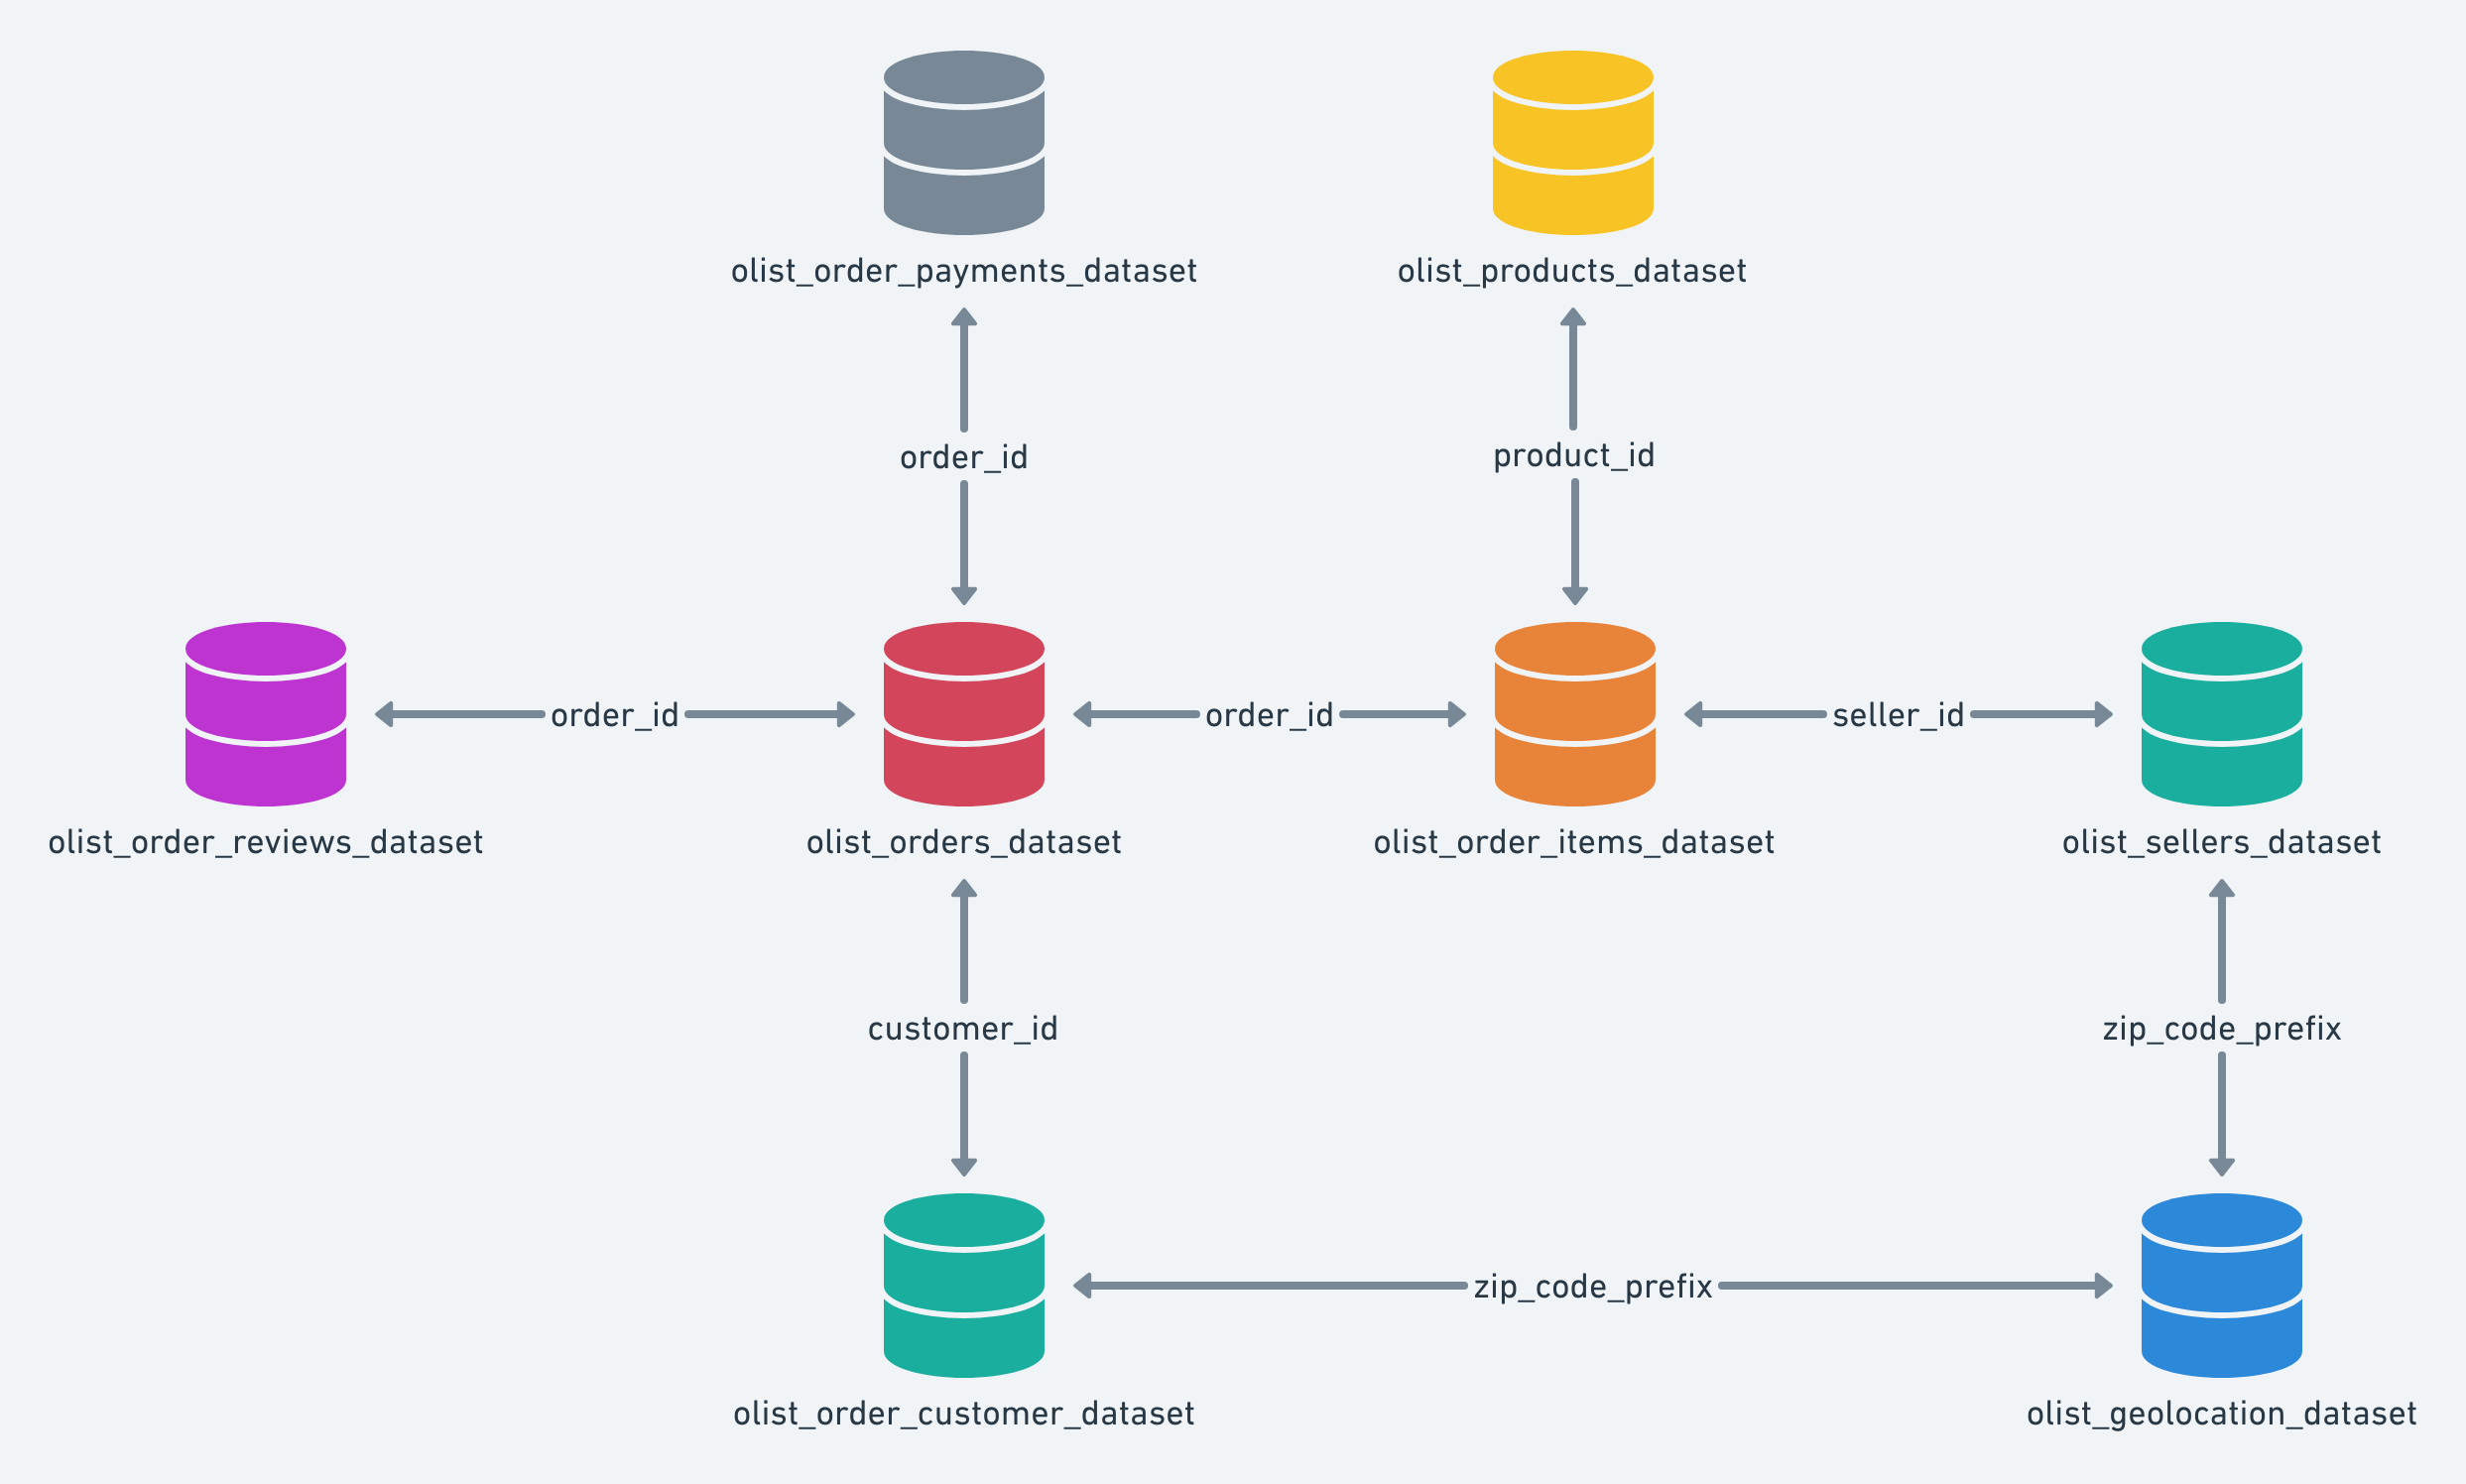

In [20]:
# Display database schema in AWS PostgreSQL
from IPython.display import Image
Image("HRhd2Y0.png")

In [7]:
import pandas as pd
import numpy as np

import psycopg2 as pg
import pandas.io.sql as pd_sql
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT


import matplotlib.pyplot as plt
import seaborn as sns

# Connecting to AWS Postgres

In [8]:
params = {
    'host': '18.218.14.63',
    'user': 'ubuntu',
    'port': 5432
}

# This is a different way of creating tables
# It is convinient if there are many columns
from sqlalchemy import create_engine
connection_string = f'postgres://ubuntu:{params["host"]}@{params["host"]}:{params["port"]}/olist'
engine = create_engine(connection_string)

In [10]:
connection = pg.connect(**params)

# Loading and Cleaning Data

## Querying Data With SQL

In [53]:
def query_aws(query, engine):
    return pd.read_sql(query,engine)

In [72]:
query = """
        SELECT 
            customers.customer_unique_id, 
            customers.customer_zip_code_prefix, 
            customers.customer_city,
            customers.customer_state,
            order_item.order_id,
            order_item.product_id,
            order_item.seller_id,
            order_item.price,
            orders.order_purchase_timestamp,
            payments.payment_type,
            payments.payment_installments,
            payments.payment_value,
            reviews.review_score,
            product_category.product_category_name_english,
            sellers.seller_zip_code_prefix,
            sellers.seller_state,
            sellers.seller_state
        FROM customers
            JOIN orders
                on orders.customer_id=customers.customer_id
            JOIN reviews
                on reviews.order_id=orders.order_id
            JOIN order_item
                on order_item.order_id=orders.order_id
            JOIN payments
                on payments.order_id=orders.order_id
            JOIN products
                on products.product_id=order_item.product_id
            JOIN product_category
                on product_category.product_category_name=products.product_category_name
            JOIN sellers
                on sellers.seller_id=order_item.seller_id
            
        """

olist_data = query_aws(query, engine)

In [73]:
# Save dataset to csv file
olist_data.to_csv('data/01_olist_aws_pulled.csv')

## Viewing and Cleaning

In [74]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 17 columns):
customer_unique_id               116581 non-null object
customer_zip_code_prefix         116581 non-null int64
customer_city                    116581 non-null object
customer_state                   116581 non-null object
order_id                         116581 non-null object
product_id                       116581 non-null object
seller_id                        116581 non-null object
price                            116581 non-null float64
order_purchase_timestamp         116581 non-null object
payment_type                     116581 non-null object
payment_installments             116581 non-null int64
payment_value                    116581 non-null float64
review_score                     116581 non-null int64
product_category_name_english    116581 non-null object
seller_zip_code_prefix           116581 non-null int64
seller_state                     116581 non-null ob

In [75]:
def duplicates(data):
    """Prints the number of duplicates in the input dataset, removes duplicate values keeping only the 
    first entry, and returns a dataset with no duplicate values."""
    
    # Confirm number of duplicate rows
    print(f"There are {data.duplicated().sum()} duplicate rows.")

    # Remove any duplicates, keeping only the first entry
    data = data.drop_duplicates(keep='first')

    # Confirm duplicates were removed correctly
    print(f"After dropping, there are {data.duplicated().sum()} duplicate rows.")
    print(f"Returned dataset has {data.shape[0]} rows")
    
    return data

In [76]:
olist_data = duplicates(olist_data)

There are 11491 duplicate rows.
After dropping, there are 0 duplicate rows.
Returned dataset has 105090 rows


In [86]:
# Convert order timestamp to datetime 
olist_data.order_purchase_timestamp = pd.to_datetime(olist_data.order_purchase_timestamp, 
                                                     format="%Y/%m/%d %H:%M:%S")

In [98]:
# Adding 99% to 7 digit summary to understand how drastic the max_price outlier is
olist_data.describe([.75,.99])

,customer_zip_code_prefix,price,payment_installments,payment_value,review_score,seller_zip_code_prefix
count,105090.000000,105090.000000,105090.000000,105090.000000,105090.000000,105090.000000
mean,35052.801342,124.520473,2.913179,158.222541,4.059901,24630.516738
std,29741.544596,189.299404,2.734677,218.818209,1.365500,27670.376941
min,1003.000000,0.850000,0.000000,0.000000,1.000000,1001.000000
50%,24360.000000,78.000000,2.000000,102.840000,5.000000,13730.000000
75%,58410.000000,139.000000,4.000000,177.357500,5.000000,29156.000000
99%,97542.000000,899.904400,10.000000,1048.310000,5.000000,93542.000000
max,99980.000000,6735.000000,24.000000,13664.080000,5.000000,99730.000000


In [113]:
# For now, not removing outliers but note that price and payment values both contain significan outliers

# EDA

In [411]:
olist_blue  = '#0C29D1'
olist_green = '#0CC78B'

## Consumers

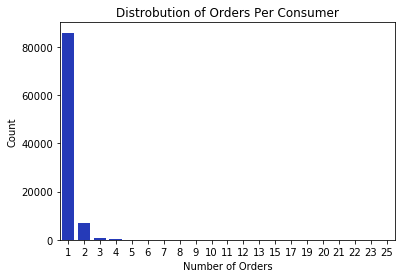

In [412]:
# Distrobution of orders per customer

def order_per_consumer(data):
    return data.groupby('customer_unique_id')['order_id'].agg(['count'])
    
orders_per_consumer = order_per_consumer(olist_data)

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
sns.countplot(orders_per_consumer['count'], color=olist_blue)
ax.set(xlabel='Number of Orders', ylabel='Count', title='Distrobution of Orders Per Consumer');

In [169]:
# Number of repeat consumers vs single time consumers

def repeat_customers(data):
    repeat_customers = data.customer_unique_id.value_counts()
    return repeat_customers[repeat_customers > 1].count()

repeat_customers(olist_data)

8272

In [255]:
# Customer locations throughout Brazil

def customer_locations(data):
    return pd.DataFrame(data.customer_city.value_counts().sort_values(ascending=False))

customer_locations = customer_locations(olist_data).reset_index().rename(columns={'index': 'city', 'customer_city':'num_customers'})

print(f"There are {customer_locations.city.nunique()} unique customer cities.\n")

top_ten_cities = customer_locations.city[:10]
customers_in_top_ten_cities = round(customer_locations.num_customers[:10].sum()/customer_locations.num_customers.sum()*100,2)

print(f"The majority of customers, {customers_in_top_ten_cities} percent, live in the top ten cities.\n")

There are 4095 unique customer cities.

The majority of customers, 35.22 percent, live in the top ten cities.



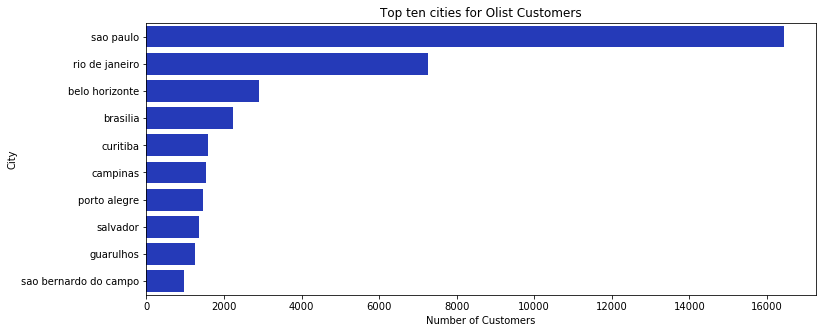

In [413]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
sns.barplot(x=customer_locations.num_customers[:10], y=top_ten_cities, ax=ax, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='City', title='Top ten cities for Olist Customers');

## Orders

In [195]:
# Number of orders per day

def order_per_day(data):
    return data.groupby(data.order_purchase_timestamp.dt.date)['order_id'].agg(['count'])

order_per_day = order_per_day(olist_data)

print(f"Avg. number of orders per day: {np.mean(order_per_day)[0]}")

Avg. number of orders per day: 170.8780487804878


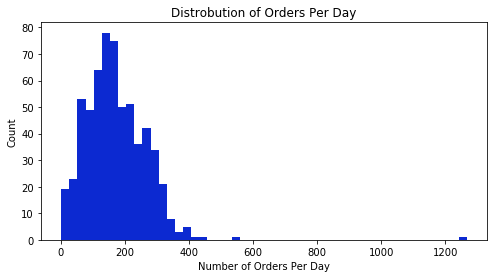

In [414]:
# Distrobution of orders per day
plt.figure(figsize=(8,4))
plt.hist(order_per_day['count'], bins=50, color=olist_blue)
plt.xlabel('Number of Orders Per Day')
plt.ylabel('Count')
plt.title('Distrobution of Orders Per Day');

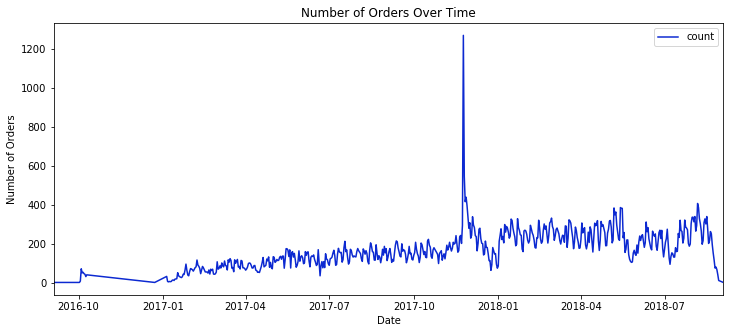

In [415]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
order_per_day.plot(ax=ax, use_index=True, color=olist_blue)
ax.set(xlabel='Date', ylabel='Number of Orders', title='Number of Orders Over Time');

There is a spike in orders around Christmas of 2017 but otherwise we see a pattern of general inflation of orders 

Avg. purchase price: 159.2856598632461


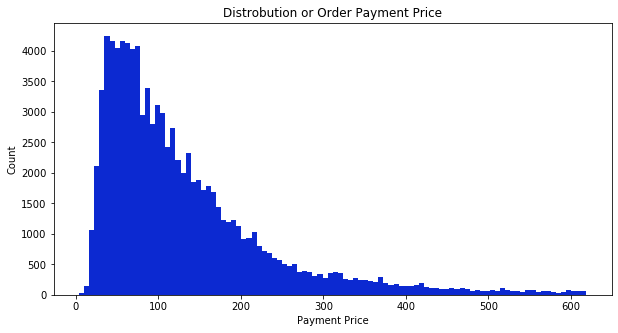

In [416]:
# Each line item represents a single item in an order. Group by order_id to find total purchase price for all orders
def purchase_payment_val(data):
    return data.groupby('order_id').payment_value.max()

purchase_payments = purchase_payment_val(olist_data)

print(f"Avg. purchase price: {purchase_payments.mean()}")


# view purchase price removing outliers in the top 3%
q_97 = purchase_payments.quantile(.97)
payments_97 = purchase_payments[purchase_payments < q_97]

# plot distrobution
plt.figure(figsize=(10,5))
plt.hist(payments_97, bins=100, color=olist_blue)
plt.xlabel('Payment Price')
plt.ylabel('Count')
plt.title('Distrobution or Order Payment Price');

In [289]:
# Number of items per order
def items_per_order(data):
    return data.groupby('order_id').product_id.agg(['count']).sort_values(by='count')

avg_items_per_order = items_per_order(olist_data).mean()

print(f"Avg. number of items per order: {avg_items_per_order[0]}")

Avg. number of items per order: 1.0805614107243844


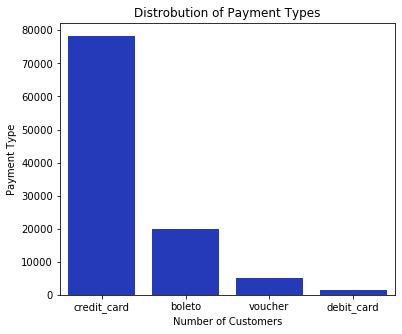

In [417]:
# Payment methods
def payment_types(data):
    return data.payment_type.value_counts()

payment_types = payment_types(olist_data)

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
sns.barplot(x=payment_types.index, y=payment_types.values, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='Payment Type', title='Distrobution of Payment Types');

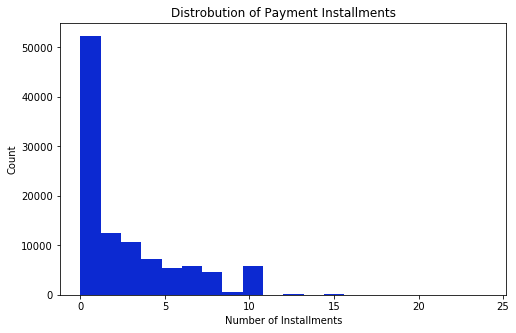

In [418]:
# Installments
plt.figure(figsize=(8,5))
plt.hist(olist_data.payment_installments, color=olist_blue, bins=20)
plt.xlabel('Number of Installments')
plt.ylabel('Count')
plt.title('Distrobution of Payment Installments');

## Sellers

In [ ]:
# Sales per seller

Avg. number of sales per seller: 34.648862512364

The top 10 sellers account for 14.28 percent of the total sales

The top seller has 2061 sales


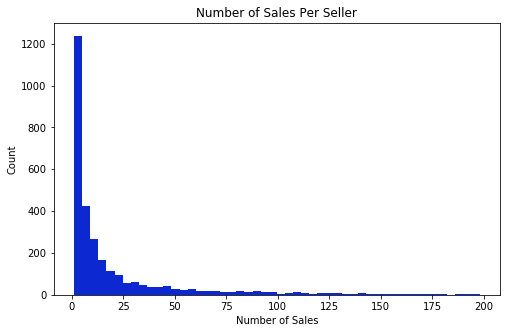

In [419]:
def sales_per_seller(data):
    return data.groupby('seller_id')['order_id'].count()

sales_per_seller = sales_per_seller(olist_data)

print(f"Avg. number of sales per seller: {sales_per_seller.mean()}\n")

top_ten_sellers = sales_per_seller.sort_values(ascending=False)[:10]
sales_in_top_ten_sellers = round(top_ten_sellers.values.sum()/sales_per_seller.values.sum()*100,2)

print(f"The top 10 sellers account for {sales_in_top_ten_sellers} percent of the total sales\n")

print(f"The top seller has {top_ten_sellers[0]} sales")

# view purchase price removing outliers in the top 3%
s_q_97 = sales_per_seller.quantile(.97)
sellers_q_97 = sales_per_seller[sales_per_seller < s_q_97]


plt.figure(figsize=(8,5))
plt.hist(sellers_q_97, bins=50, color=olist_blue)
plt.xlabel('Number of Sales')
plt.ylabel('Count')
plt.title('Number of Sales Per Seller');

## Products

Average price per product: 124.52047283280997

Average sales per product: 3.2507423904974018

Top ten selling products:
99a4788cb24856965c36a24e339b6058    504
aca2eb7d00ea1a7b8ebd4e68314663af    437
422879e10f46682990de24d770e7f83d    367
d1c427060a0f73f6b889a5c7c61f2ac4    335
389d119b48cf3043d311335e499d9c6b    320
53b36df67ebb7c41585e8d54d6772e08    310
53759a2ecddad2bb87a079a1f1519f73    300
368c6c730842d78016ad823897a372db    298
154e7e31ebfa092203795c972e5804a6    274
2b4609f8948be18874494203496bc318    266
Name: product_id, dtype: int64

The top ten selling products account for 3.25 percent of the product sold.



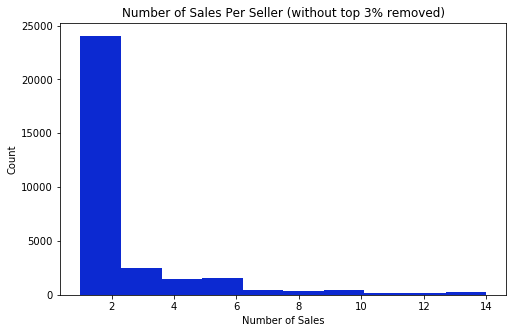

In [420]:
# Average product cost
print(f"Average price per product: {olist_data.price.mean()}\n")

# Most sold products
def num_products_sold(data):
    return data.product_id.value_counts()

number_prod_sold = num_products_sold(olist_data)

print(f"Average sales per product: {number_prod_sold.mean()}\n")

top_ten_products = number_prod_sold[:10]
print(f"Top ten selling products:\n{top_ten_products}\n")
print(f"The top ten selling products account for {round(top_ten_products.values.sum()/number_prod_sold.values.sum()*100,2)} percent of the product sold.\n")


p_q_97 = number_prod_sold.quantile(.97)
products_q_97 = number_prod_sold[number_prod_sold < p_q_97]

plt.figure(figsize=(8,5))
plt.hist(products_q_97, bins=10, color=olist_blue)
plt.xlabel('Number of Sales')
plt.ylabel('Count')
plt.title('Number of Sales Per Seller (without top 3% removed)');

In [392]:
# Top reviewed products as determined by rating and number of reviews
def product_reviews(data):
    return data.groupby('product_id')['review_score'].agg(['mean', 'count']).reset_index()

top_ten_reviewed_products = product_reviews(olist_data).sort_values(by=['mean','count'],ascending=False)[:10]

print(f"The top reviewed products are\n {top_ten_reviewed_products}")

The top reviewed products are
                              product_id  mean  count
627    0554911df28fda9fd668ce5ba5949695   5.0     17
16932  85b99d83c60cab5b4d8f927ad35212a1   5.0     17
25529  ca0019454bd5ddca0f4022fe89f6557a   5.0     14
5081   2722b7e5f68e776d18fe901638034e54   5.0     13
18471  926a505f318353d8634f3c5102756352   5.0     13
995    07f01b6fcacc1b187a71e5074199db2d   5.0     12
9761   4c8b28305f570899b6ded964ddd234a9   5.0     12
11433  59c1840441f4df065f52760bf51a8442   5.0     11
16420  8173ca41cdb176462f9ae79821a48404   5.0     11
17603  8b6ed41158b194711f83b8da92757544   5.0     11


# Feature Engineering

# Modeling